# Assignment 3 - Quantum Communication 

### <span style="color:#61c2e8">Task 4</span>: Quantum Repeater Networks 

One of the potential practical applications of quantum teleportation is in quantum communication networks. One proposed architecture, the quantum repeater, uses local teleportations to propagate a Bell pair across space. Once a Bell pair has been shared, it can be used to perform quantum teleportation from one end of the network to the other. 

> In quantum computing it is assumed that it is easy to physically implement the operations required for Bell state measurement. If the optical circuit used to realize a Bell state measurement on flying optical qubits is restricted to using passive linear optical elements (beam-splitters and phase shifters), the Bell state measurement has at most a 50% success rate [J. Calsamiglia and N. Lutkenhaus, Applied Physics B: Lasers and Optics 72, 67 (2001)]. Using nonlinear elements (e.g. the CNOT gate operation), the Bell state measurement can be implemented with a 100% success rate. In optics, the nonlinear operation that would allow us to avoid this bottleneck cannot be efficiently implemented. The example below shows how to implement a repeater network in the context of teleportation between stationary qubits of a quantum processor where such nonlinear operation can be implemented efficiently.

#### Run these cells before beginning to import necessary packages.
This cell may take a minute or more to complete. Importing qsharp triggers a sequence of actions which allow us to compile and run Q# code in this notebook.

In [1]:
import qsharp
import qsharp.azure
import matplotlib.pyplot as plt
import qsharp.experimental
import qutip as qt

Preparing Q# environment...


In [2]:
%%qsharp
open Microsoft.Quantum.Diagnostics; 
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Random;
open Microsoft.Quantum.Math;

We begin implementing this protocol by defining two operations: `BellStateMeasurement` and `TeleportationFixup`. These are nearly identical to the `Sender` and `Receiver` operations in task 2. However, this time the operation performing Bell state measurement (previously the sender) will not be preparing a state, because now this operation will just propagate a Bell state down an array.

In [3]:
%%qsharp

/// # Summary
/// Perform a Bell state measurement and return the Results in a tuple.
///
/// # Input
/// ## q1
/// The first qubit in the measurement scheme.
/// ## q2
/// The second qubit in the measurement scheme.
///
/// # Output
/// A tuple of results which indicate the result of the Bell state measurement.

operation BellStateMeasurement(q1 : Qubit, q2 : Qubit) : (Result, Result) {
    CNOT(q1, q2);
    H(q1);
    return (M(q1), M(q2));
}

/// # Summary
/// Based on a Bell state measurement result, applies the correct fixup gates
/// to a qubit to complete the teleportation protocol.
/// 
/// # Input
/// ## q
/// Qubit which is acted on.
///
/// ## (m1, m2) 
/// Tuple returned from BellStateMeasurement which tells us the outcome of the Bell state measurement.

operation TeleportationFixup(q : Qubit, (m1 : Result, m2 : Result)): Unit {
    if m1 == One {
        Z(q);
    }
    if m2 == One {
        X(q);
    }
}

With these two operations we can now implement the top-level `QuantumRepeater` operation. We will limit the length of our repeater network to a power of 2. This will greatly simplify the implementation, since the process of spreading the Bell pair over the array doubles the distance between the qubits of the Bell pairs with each iteration.

This operation will perform four steps:

1. Allocate a qubit array of length $2^N$.
2. Prepare each adjacent pair of qubits into a Bell pair.
3. Repeatedly perform the teleportation protocol between adjacent qubit pairs. In this way the distance between the qubits of Bell pairs can be increased until the first and last qubits are the only remaining Bell pair.
4. Use the Bell pair which is now spread over a large distance to perform the teleportation protocol with another qubit.  

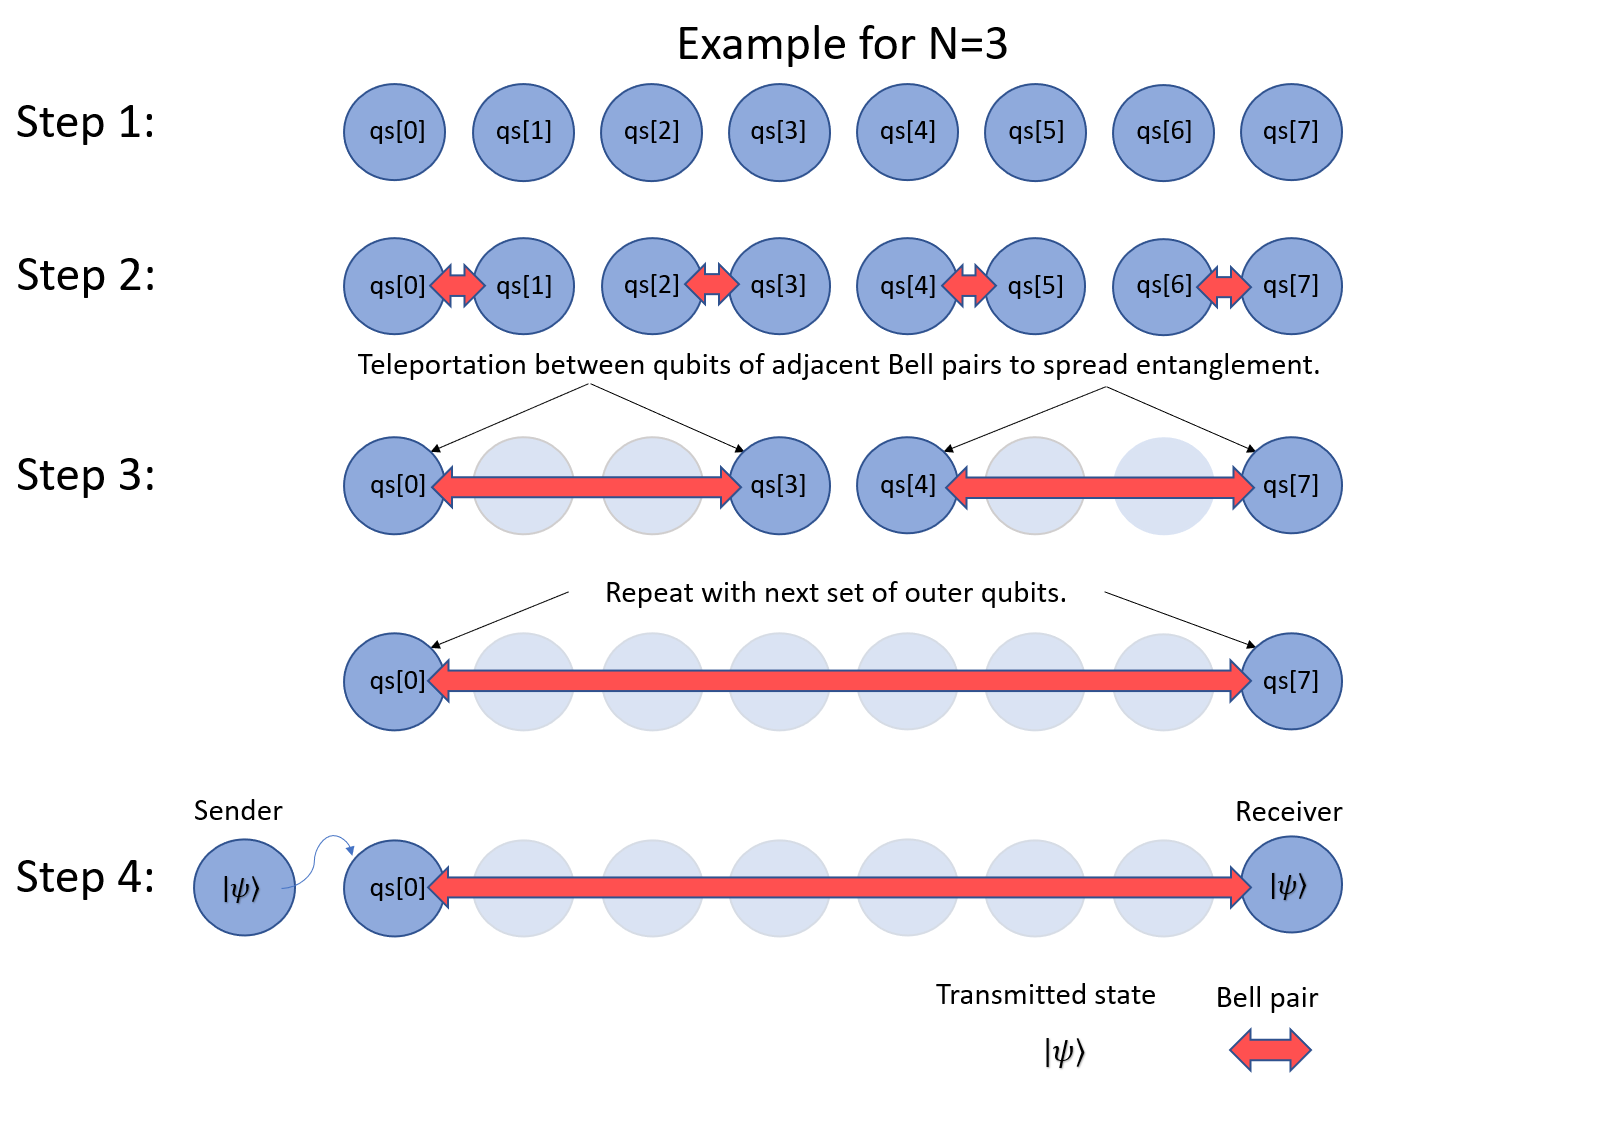

In [4]:
%%qsharp
// # Summary
/// Takes a qubit and applies an Ry to it.
///
/// # Input
/// ## q
/// The input qubit

operation StatePrepare(q : Qubit) : Unit is Adj {
    Ry(3.1415 / 7.0, q);
}

/// # Summary
/// The top-level quantum repeater operation
/// that implements all steps of a repeater network
///
/// # Input
/// ## N
/// An integer which gives us the length of the repeater network.
/// The network will have 2^N qubits.
///
/// # Output
/// A result of measuring the final qubit in the repeater network
/// after a state is teleported to it and the adjoint of the PrepareState 
/// operation is applied, so this result should always be Zero.

operation QuantumRepeater(N : Int) : Result {
    use qs = Qubit[2 ^ N];
    // Prepare the Bell pairs
    for i in 0 .. 2 .. Length(qs) - 1 {
        H(qs[i]);
        CNOT(qs[i], qs[i+1]);
    }
    // In this block iteratively teleport states 
    // to entangle more and more distant pairs of qubits
    // until we entangle the two ends of the array.
    for power in 2 .. N {
        let step = 2 ^ power;
        for i in 0 .. step .. Length(qs) - 1 {
            let q1Idx = i + step / 2 - 1;
            let q2Idx = q1Idx + 1;

            let bsm = BellStateMeasurement(qs[q1Idx], qs[q2Idx]);
            TeleportationFixup(qs[i + step - 1], bsm);
        }
    }
    // Allocate a new qubit and prepare a state to teleport.
    use qToTeleport = Qubit();
    StatePrepare(qToTeleport);

    // Teleport the state.
    let bsm = BellStateMeasurement(qToTeleport, qs[0]);
    TeleportationFixup(qs[Length(qs) - 1], bsm);

    // Apply Adjoint of the state preparation to the teleportation target.
    // It should end up in the |0⟩ state.
    Adjoint StatePrepare(qs[Length(qs) - 1]);
    return M(qs[Length(qs) - 1]);
}

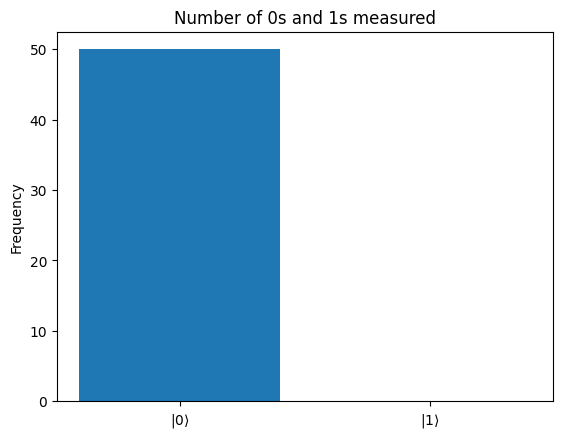

In [5]:
shots = 50
results = [0, 0]
for i in range(shots):
    results[QuantumRepeater.simulate(N = 2)] += 1
plt.bar([0, 1], results, tick_label = [r"$|0\rangle$", r"$|1\rangle$"])
plt.ylabel("Frequency")
plt.title("Number of 0s and 1s measured")
plt.show()

Since this is a noiseless simulation, we always measure $|0\rangle$. However, any near-term repeater-based quantum network will not be noiseless. To better understand how noise will affect transmission, let's create a simple noise model.

For our noise model we will add noise to the H and CNOT gate operations. We will do this by enabling the Q# noisy simulator and then updating these gates' noise models. We will use a simple bit flip model: whenever we use an H or CNOT gate, there is a probability $p$ of an X gate being applied (in the case of the CNOT gate, it will be applied to the target qubit only).

Here we will define a function `set_noise_model(p)` so we can configure the noise on the fly.

In [17]:
qsharp.experimental.enable_noisy_simulation()
I = qt.qeye(2)
X = qt.sigmax()

def set_noise_model(p):
    noise_model = qsharp.experimental.get_noise_model_by_name('ideal')
    noise_model.h = (p * X + (1-p) * I) * qt.qip.operations.hadamard_transform() 
    noise_model.cnot = qt.super_tensor(qt.to_super(I), (1 - p) * qt.to_super(I) + p * qt.to_super(X)) * qt.to_super(qt.qip.operations.cnot())
    qsharp.experimental.set_noise_model(noise_model)

Once we have defined the above function, we can create our noise model and simulate the repeater network.

In [18]:
set_noise_model(0.3)
qsharp.config['simulators.noisy.nQubits'] = 2**2 + 1
QuantumRepeater.simulate_noise(N=2)

0

Now let's look how the percentage of correct transmissions varies as we change the size of the network and the noise probability $p$.

25.0% done
50.0% done
75.0% done
100.0% done


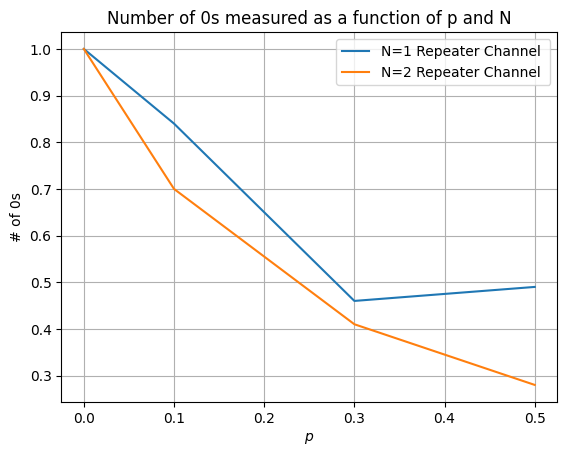

In [19]:
shots = 100
NRange = [1, 2] 
pRange = [0, .1, .3, .5] 
results = [[] for i in pRange]
for (idx, p) in enumerate(pRange):
    set_noise_model(p)
    for N in NRange: 
        qsharp.config['simulators.noisy.nQubits'] = 2**N + 1
        numZeros = 0
        for i in range(shots):
            if QuantumRepeater.simulate_noise(N = N) == 0:
                numZeros += 1
        results[idx].append(numZeros/shots)
    print("{}% done".format(100 * ((1+idx)/len(pRange))))
plt.plot(pRange, results)
legend = ["N={} Repeater Channel ".format(i) for i in NRange]
plt.legend(legend)
plt.xlabel(r"$p$")
plt.ylabel("# of 0s")
plt.title("Number of 0s measured as a function of p and N")   
plt.grid()     
plt.show()

Technically the number of times a 0 is measured isn't the success rate of the network. Since for some errors the final state could be a superposition state $\alpha|0\rangle + \beta|1\rangle$, the end result of measurement can still be a 0, even though this state was not what we wanted to teleport. However, we cannot distinguish these two cases with our current implementation. Instead, we'll use this value as an estimate of the upper bound of the success rate of the network, since measuring 1 always indicates failure.

### <span style="color:#61c2e8">Task 4 Questions</span>:

* T4.1. Please explain this plot. What happens as we vary the parameters $N$ and $p$?


##### T 4.1

If in the quantum repeater chain any, even number of flips occur due to the presence of the operation of the $X$ gate on each qubit, then we would still measure a $0$. The probability of one flip is $p$. Now, consider a reaper chain with two qubits, that is $N=1$.Then we will measure a $0$ if none of the qubits flip, or both the qubits flip. THerefore, the probability of meauring a $0$ is $(1-p)^2+p^2$. For $N=1$ and $p=0$, when the input qubit is $\ket{0}$ then the probability of measuring a $\ket{0}$ is $1$. If $p=0.1$ then the probability of measuring a $0$ is $0.82$. Similaryly, if $p=0.2$ the probability of measuring a $\ket{0}$ is $0.68$, and so on. This is what we observe in the graph shown above. When $N=2$, that is there are $4$ qubits, then the target measure $\ket{0}$ if $(1)$ there are no flips with probability of $(1-p)^4$, $(2)$ there are exactly two flips with probability ${4\choose 2} p^2(1-p)^2$, and $(3)$ all four qubits flip with probability $p^4$. Therefore, the probability fo measuring a $\ket{0}$ when the target is $\ket{0}$ is $p^4+{4\choose 2} p^2(1-p)^2+p^4$. This is what is observed in the graph. As $p$ increases, holding $N$ constant the probability of measuign a $\ket{0}$ decreases. Also as $N$ increases, holding $p$ constant, the probaility of measuing a $\ket{0}$ decreases. 